In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
#torch.multiprocessing.set_start_method('spawn')
import glob
import matplotlib.pyplot as plt

from torch.utils.data import ConcatDataset, DataLoader
from catalyst import dl
from catalyst.utils import metrics
from torch.nn import functional as F

from vxs import *

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [2]:
if torch.cuda.is_available():
    print(torch.cuda.current_device())

In [3]:
vocal_sketch_dataset = SampleSet(glob.glob('../data/vocal_imitations_sketch_included/included/*.wav'))
drum_machines_dataset = SampleSet(glob.glob('../data/200DrumMachines/*/*.wav'))
avp_set_fixed = SampleSet(tracks=SegmentSet(AVPTrackSet('../data/AVP_Dataset', subset='Fixed'),
                                            frame_window=65536, return_class=False))
common_set = ConcatDataset([vocal_sketch_dataset, drum_machines_dataset, avp_set_fixed])

In [4]:
len(common_set)

15649

In [5]:
len(drum_machines_dataset)

6749

In [6]:
len(vocal_sketch_dataset)

4429

In [7]:
# Pre-caching all the specgrams
for i in range(len(common_set)):
    _ = common_set[i]
    if i % 500 == 0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500


In [8]:
class ConvAERunner(dl.Runner):
    def _handle_batch(self, batch):
        x = batch          # ignore the raw waveform
        y, z = self.model(x)
        loss = F.mse_loss(y, x)
        self.batch_metrics = {
            'loss': loss
        }
        
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

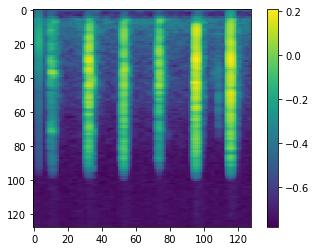

In [9]:
def sample_random(num, ln, seed):
    np.random.seed(seed)
    return np.random.randint(0, ln, size=num)

def imshow_random_samples(dataset, num, random_seed=42, cols=3):
    samples = sample_random(num, len(dataset), random_seed)
    rows = num // cols + (0 if num % cols == 0 else 1)
    fig, axes_t = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = [ax for tp in axes_t for ax in tp]
    
    for (sample_idx, ax) in zip(samples, axes):
        sample = dataset[sample_idx]
        ax.imshow(sample.cpu().squeeze(0).numpy())
        ax.set_title(sample_idx)
        
    plt.show()
    
def imshow_ae_output(model, dataset, num, random_seed=42):
    samples = sample_random(num, len(dataset), random_seed)
    fig, axes = plt.subplots(num, 3, figsize=(12, 4*num))
    
    for (sample_idx, (ax1, ax2, ax3)) in zip(samples, axes):
        sample = dataset[sample_idx].cpu()
        sample_out, z = model(sample.unsqueeze(0))
        ax1.imshow(sample.squeeze().numpy())
        ax2.imshow(sample_out.detach().squeeze().numpy())
        ax3.imshow(z.detach().squeeze().flatten(1).numpy())
        
    plt.show()
    
melgram = common_set[42][0]
im = plt.imshow(melgram.cpu().squeeze(0).numpy())
plt.colorbar(im)
plt.show()

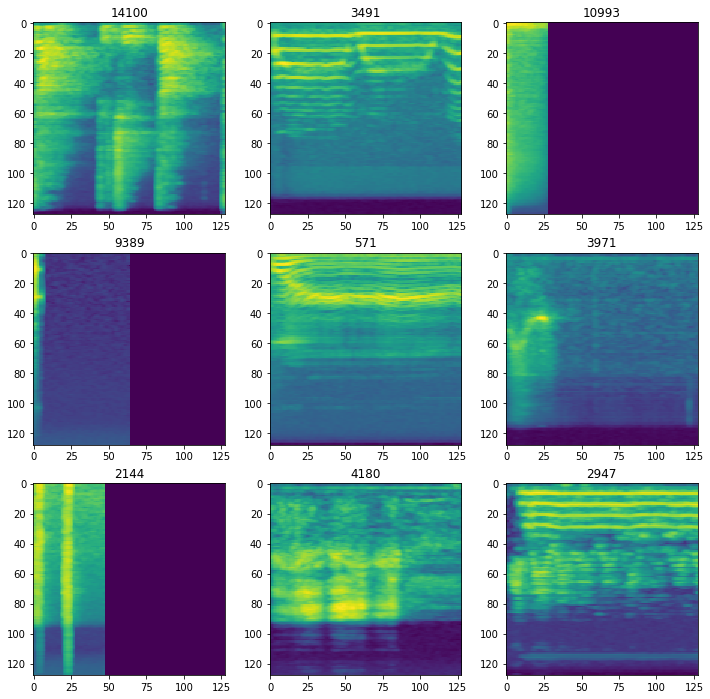

In [10]:
imshow_random_samples(common_set, 9, random_seed=44, cols=3)

In [22]:
splitter = DataSplit(common_set, shuffle=True, test_train_split=1)
loaders = {
    'train': splitter.get_train_loader(),
    'valid': splitter.get_validation_loader()
}

model = ConvAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
model.load_state_dict(torch.load('../logs/conv_ae_fixed_2/checkpoints/best.pth')['model_state_dict'])
model.eval()

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), padding_mode=reflect)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4), padding_mode=reflect)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 24, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4), padding_mode=reflect)
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(24, 32, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4), padding_mode=reflect)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): UpsamplingBilinear2d(scale_factor=(2.0, 2.0), mode=bilinear)
    (1): Conv2

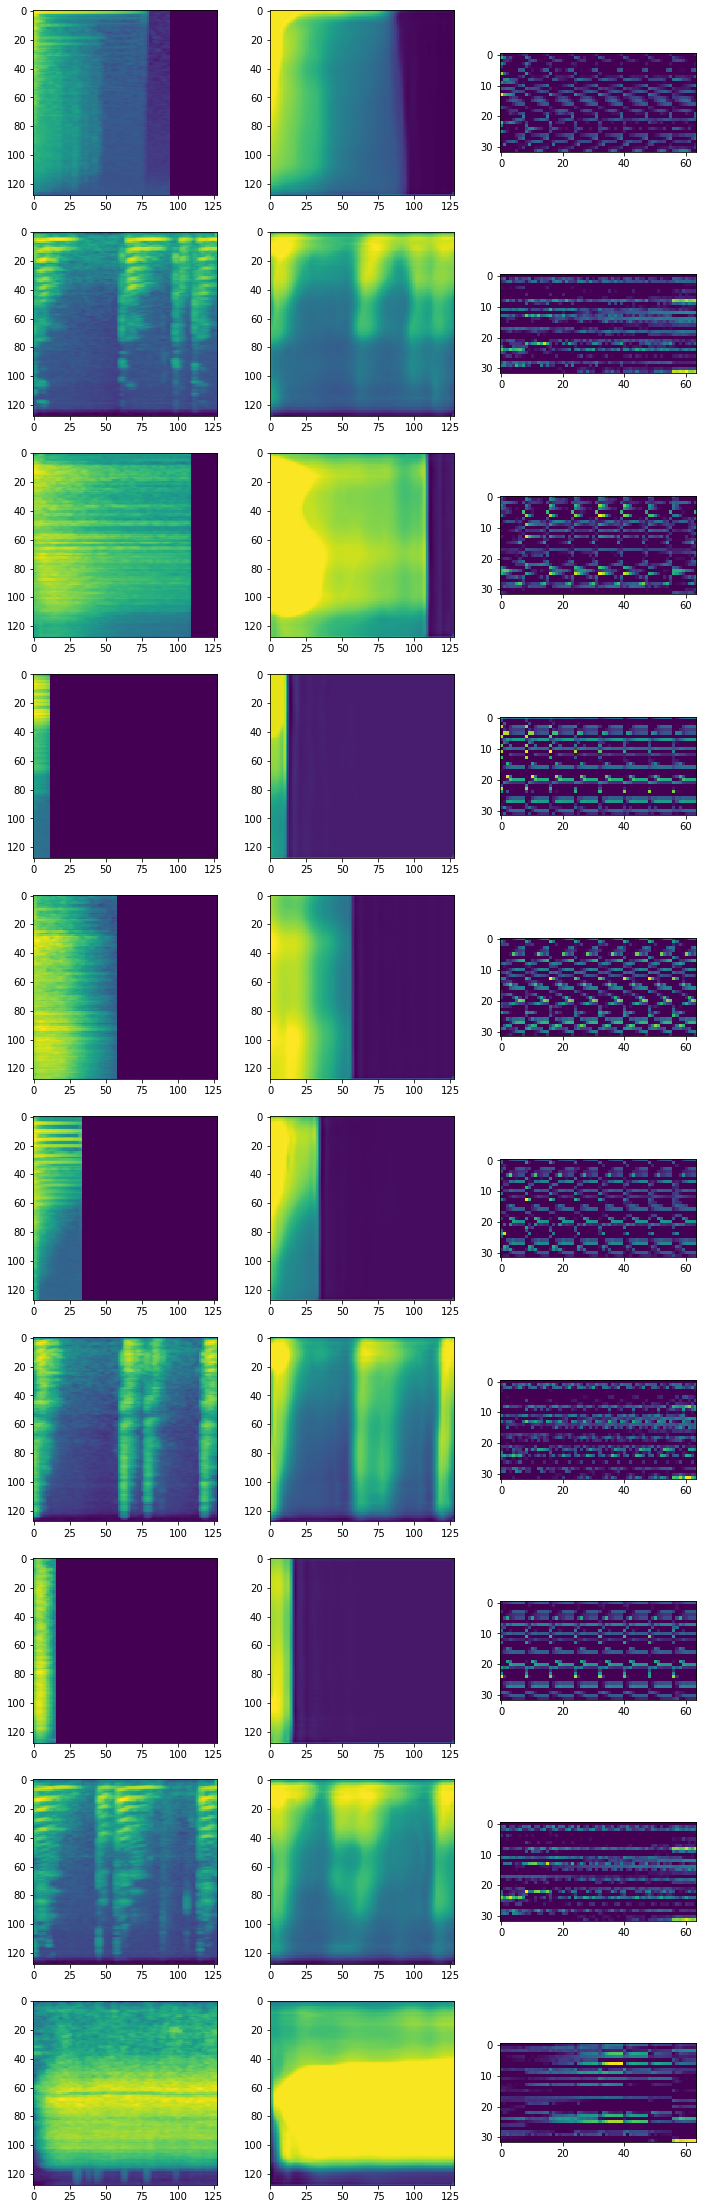

In [24]:
imshow_ae_output(model, common_set, 10, random_seed=455)

In [21]:
runner = ConvAERunner()
runner.train(
    model=model, 
    optimizer=optimizer, 
    loaders=loaders,
    num_epochs=10,
    verbose=True,
    timeit=False,
    logdir="../logs/conv_ae_fixed_2_tmp"
)


1/10 * Epoch (train):   0% 0/282 [00:00<?, ?it/s]
1/10 * Epoch (train):   0% 0/282 [00:01<?, ?it/s, loss=0.698]
1/10 * Epoch (train):   0% 1/282 [00:01<04:53,  1.04s/it, loss=0.698]
1/10 * Epoch (train):   0% 1/282 [00:01<04:53,  1.04s/it, loss=0.529]
1/10 * Epoch (train):   1% 2/282 [00:01<04:37,  1.01it/s, loss=0.529]
1/10 * Epoch (train):   1% 2/282 [00:02<04:37,  1.01it/s, loss=0.578]
1/10 * Epoch (train):   1% 3/282 [00:02<04:26,  1.05it/s, loss=0.578]
1/10 * Epoch (train):   1% 3/282 [00:03<04:26,  1.05it/s, loss=0.452]
                                                 .08it/s, loss=0.452]
                                                                  Early exiting
1/20 * Epoch (train):   0% 0/282 [01:59<?, ?it/s]
1/10 * Epoch (train):   1% 4/282 [00:03<04:18,  1.08it/s, loss=0.452]

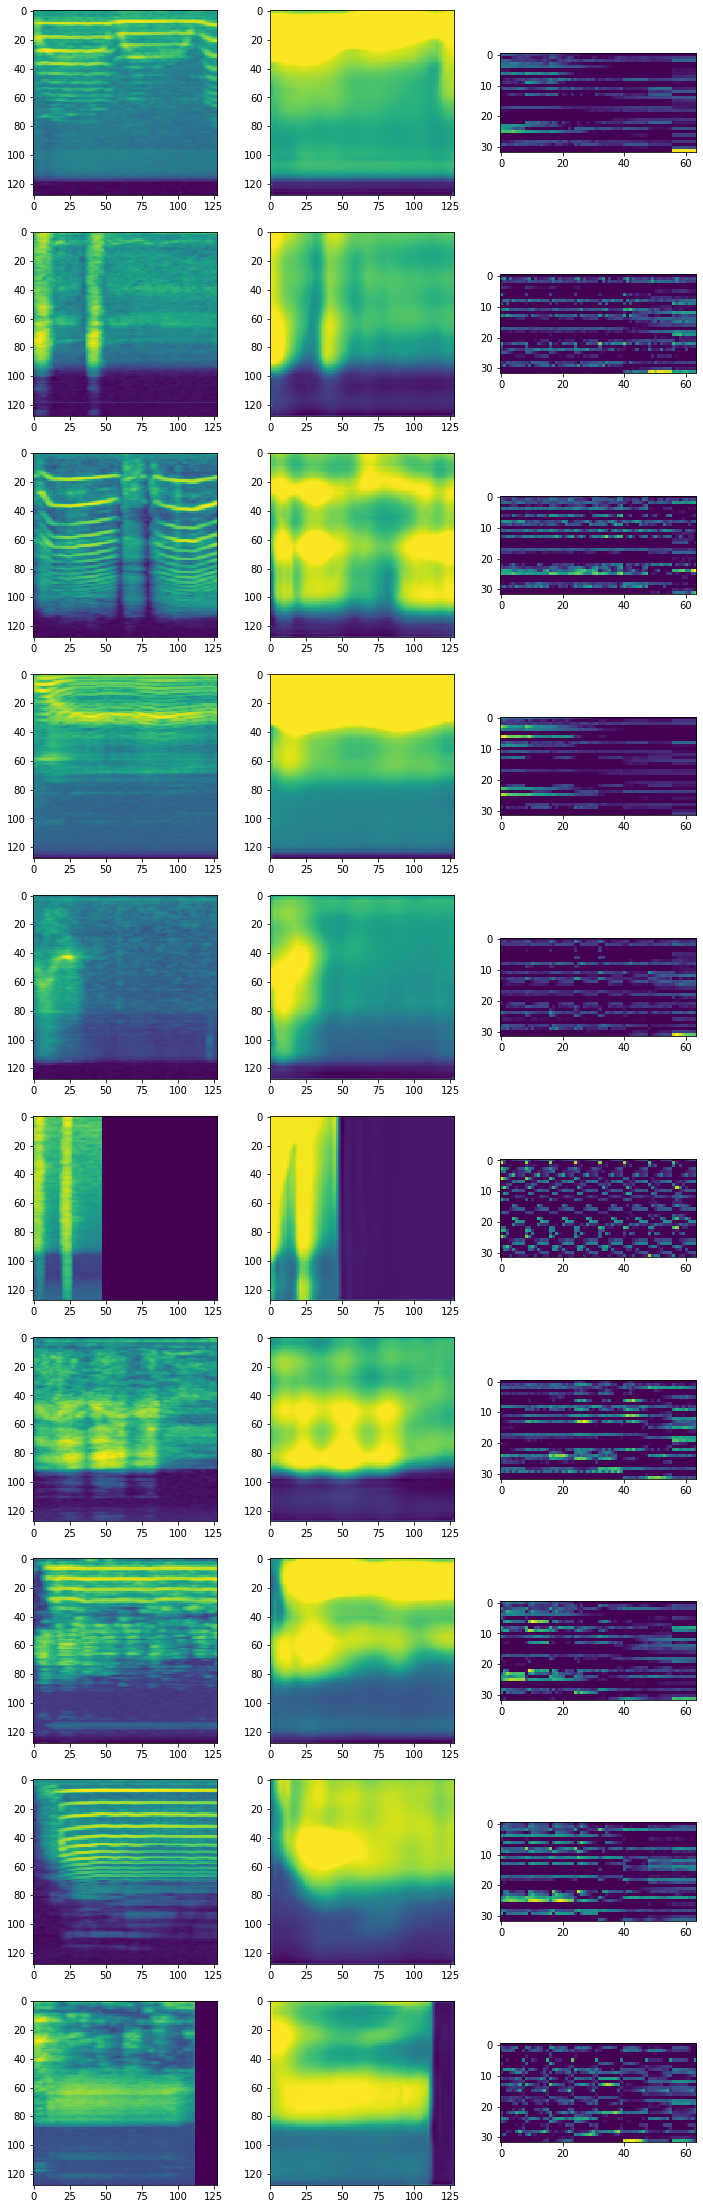

In [22]:
model.eval()
imshow_ae_output(model, vocal_sketch_dataset, 10, random_seed=44)

In [12]:
model_wide = ConvAE(outer_kernel_size=(3,5), strides=[(2,2),(4,2),(4,2),(4,4)], padding_mode='zeros')
optimizer_wide = torch.optim.Adam(model_wide.parameters(), lr=0.001)

In [13]:
runner = ConvAERunner()
runner.train(
    model=model_wide, 
    optimizer=optimizer_wide, 
    loaders=loaders,
    num_epochs=20,
    verbose=True,
    timeit=False,
    logdir="../logs/conv_ae_fixed_wide_2"
)

1/20 * Epoch (train): 100% 282/282 [02:52<00:00,  1.64it/s, loss=0.026]
1/20 * Epoch (valid): 100% 32/32 [00:11<00:00,  2.86it/s, loss=0.023]
[2020-07-17 00:12:13,708] 
1/20 * Epoch 1 (train): loss=0.0672
1/20 * Epoch 1 (valid): loss=0.0229


INFO:metrics_logger:
1/20 * Epoch 1 (train): loss=0.0672
1/20 * Epoch 1 (valid): loss=0.0229


2/20 * Epoch (train): 100% 282/282 [02:51<00:00,  1.64it/s, loss=0.027]
2/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.30it/s, loss=0.018]
[2020-07-17 00:15:15,409] 
2/20 * Epoch 2 (train): loss=0.0225
2/20 * Epoch 2 (valid): loss=0.0180


INFO:metrics_logger:
2/20 * Epoch 2 (train): loss=0.0225
2/20 * Epoch 2 (valid): loss=0.0180


3/20 * Epoch (train): 100% 282/282 [02:50<00:00,  1.65it/s, loss=0.019]
3/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.27it/s, loss=0.014]
[2020-07-17 00:18:16,883] 
3/20 * Epoch 3 (train): loss=0.0171
3/20 * Epoch 3 (valid): loss=0.0145


INFO:metrics_logger:
3/20 * Epoch 3 (train): loss=0.0171
3/20 * Epoch 3 (valid): loss=0.0145


4/20 * Epoch (train): 100% 282/282 [02:49<00:00,  1.66it/s, loss=0.018]
4/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.30it/s, loss=0.011]
[2020-07-17 00:21:16,877] 
4/20 * Epoch 4 (train): loss=0.0148
4/20 * Epoch 4 (valid): loss=0.0127


INFO:metrics_logger:
4/20 * Epoch 4 (train): loss=0.0148
4/20 * Epoch 4 (valid): loss=0.0127


5/20 * Epoch (train): 100% 282/282 [02:50<00:00,  1.65it/s, loss=0.012]
5/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.31it/s, loss=0.012]
[2020-07-17 00:24:18,084] 
5/20 * Epoch 5 (train): loss=0.0135
5/20 * Epoch 5 (valid): loss=0.0120


INFO:metrics_logger:
5/20 * Epoch 5 (train): loss=0.0135
5/20 * Epoch 5 (valid): loss=0.0120


6/20 * Epoch (train): 100% 282/282 [02:50<00:00,  1.65it/s, loss=0.011]
6/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.31it/s, loss=0.012]
[2020-07-17 00:27:19,154] 
6/20 * Epoch 6 (train): loss=0.0126
6/20 * Epoch 6 (valid): loss=0.0108


INFO:metrics_logger:
6/20 * Epoch 6 (train): loss=0.0126
6/20 * Epoch 6 (valid): loss=0.0108


7/20 * Epoch (train): 100% 282/282 [02:49<00:00,  1.66it/s, loss=0.011]
7/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.30it/s, loss=0.008]
[2020-07-17 00:30:19,721] 
7/20 * Epoch 7 (train): loss=0.0113
7/20 * Epoch 7 (valid): loss=0.0103


INFO:metrics_logger:
7/20 * Epoch 7 (train): loss=0.0113
7/20 * Epoch 7 (valid): loss=0.0103


8/20 * Epoch (train): 100% 282/282 [02:54<00:00,  1.62it/s, loss=0.013]
8/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.32it/s, loss=0.013]
[2020-07-17 00:33:24,132] 
8/20 * Epoch 8 (train): loss=0.0111
8/20 * Epoch 8 (valid): loss=0.0101


INFO:metrics_logger:
8/20 * Epoch 8 (train): loss=0.0111
8/20 * Epoch 8 (valid): loss=0.0101


9/20 * Epoch (train): 100% 282/282 [02:51<00:00,  1.65it/s, loss=0.010]
9/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.29it/s, loss=0.010]
[2020-07-17 00:36:25,658] 
9/20 * Epoch 9 (train): loss=0.0100
9/20 * Epoch 9 (valid): loss=0.0093


INFO:metrics_logger:
9/20 * Epoch 9 (train): loss=0.0100
9/20 * Epoch 9 (valid): loss=0.0093


10/20 * Epoch (train): 100% 282/282 [04:14<00:00,  1.11it/s, loss=0.010]
10/20 * Epoch (valid): 100% 32/32 [00:20<00:00,  1.58it/s, loss=0.009]
[2020-07-17 00:41:00,518] 
10/20 * Epoch 10 (train): loss=0.0101
10/20 * Epoch 10 (valid): loss=0.0096


INFO:metrics_logger:
10/20 * Epoch 10 (train): loss=0.0101
10/20 * Epoch 10 (valid): loss=0.0096


11/20 * Epoch (train): 100% 282/282 [06:00<00:00,  1.28s/it, loss=0.008]
11/20 * Epoch (valid): 100% 32/32 [00:19<00:00,  1.67it/s, loss=0.008]
[2020-07-17 00:47:20,850] 
11/20 * Epoch 11 (train): loss=0.0094
11/20 * Epoch 11 (valid): loss=0.0090


INFO:metrics_logger:
11/20 * Epoch 11 (train): loss=0.0094
11/20 * Epoch 11 (valid): loss=0.0090


12/20 * Epoch (train): 100% 282/282 [03:58<00:00,  1.18it/s, loss=0.010]
12/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.32it/s, loss=0.013]
[2020-07-17 00:51:29,572] 
12/20 * Epoch 12 (train): loss=0.0120
12/20 * Epoch 12 (valid): loss=0.0094


INFO:metrics_logger:
12/20 * Epoch 12 (train): loss=0.0120
12/20 * Epoch 12 (valid): loss=0.0094


13/20 * Epoch (train): 100% 282/282 [02:49<00:00,  1.66it/s, loss=0.010]
13/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.31it/s, loss=0.010]
[2020-07-17 00:54:29,376] 
13/20 * Epoch 13 (train): loss=0.0100
13/20 * Epoch 13 (valid): loss=0.0090


INFO:metrics_logger:
13/20 * Epoch 13 (train): loss=0.0100
13/20 * Epoch 13 (valid): loss=0.0090


14/20 * Epoch (train): 100% 282/282 [02:50<00:00,  1.66it/s, loss=0.009]
14/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.32it/s, loss=0.010]
[2020-07-17 00:57:29,582] 
14/20 * Epoch 14 (train): loss=0.0096
14/20 * Epoch 14 (valid): loss=0.0091


INFO:metrics_logger:
14/20 * Epoch 14 (train): loss=0.0096
14/20 * Epoch 14 (valid): loss=0.0091


15/20 * Epoch (train): 100% 282/282 [02:49<00:00,  1.66it/s, loss=0.009]
15/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.29it/s, loss=0.009]
[2020-07-17 01:00:29,435] 
15/20 * Epoch 15 (train): loss=0.0093
15/20 * Epoch 15 (valid): loss=0.0087


INFO:metrics_logger:
15/20 * Epoch 15 (train): loss=0.0093
15/20 * Epoch 15 (valid): loss=0.0087


16/20 * Epoch (train): 100% 282/282 [02:49<00:00,  1.66it/s, loss=0.009]
16/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.32it/s, loss=0.009]
[2020-07-17 01:03:29,421] 
16/20 * Epoch 16 (train): loss=0.0090
16/20 * Epoch 16 (valid): loss=0.0079


INFO:metrics_logger:
16/20 * Epoch 16 (train): loss=0.0090
16/20 * Epoch 16 (valid): loss=0.0079


17/20 * Epoch (train): 100% 282/282 [02:49<00:00,  1.66it/s, loss=0.009]
17/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.31it/s, loss=0.008]
[2020-07-17 01:06:29,428] 
17/20 * Epoch 17 (train): loss=0.0087
17/20 * Epoch 17 (valid): loss=0.0080


INFO:metrics_logger:
17/20 * Epoch 17 (train): loss=0.0087
17/20 * Epoch 17 (valid): loss=0.0080


18/20 * Epoch (train): 100% 282/282 [02:49<00:00,  1.66it/s, loss=0.009]
18/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.31it/s, loss=0.012]
[2020-07-17 01:09:29,412] 
18/20 * Epoch 18 (train): loss=0.0087
18/20 * Epoch 18 (valid): loss=0.0083


INFO:metrics_logger:
18/20 * Epoch 18 (train): loss=0.0087
18/20 * Epoch 18 (valid): loss=0.0083


19/20 * Epoch (train): 100% 282/282 [02:50<00:00,  1.65it/s, loss=0.009]
19/20 * Epoch (valid): 100% 32/32 [00:09<00:00,  3.32it/s, loss=0.008]
[2020-07-17 01:12:30,382] 
19/20 * Epoch 19 (train): loss=0.0085
19/20 * Epoch 19 (valid): loss=0.0080


INFO:metrics_logger:
19/20 * Epoch 19 (train): loss=0.0085
19/20 * Epoch 19 (valid): loss=0.0080


Early exiting                                                           


In [15]:
model_wide.load_state_dict(torch.load('../logs/conv_ae_fixed_wide_2/checkpoints/best.pth')['model_state_dict'])


<All keys matched successfully>

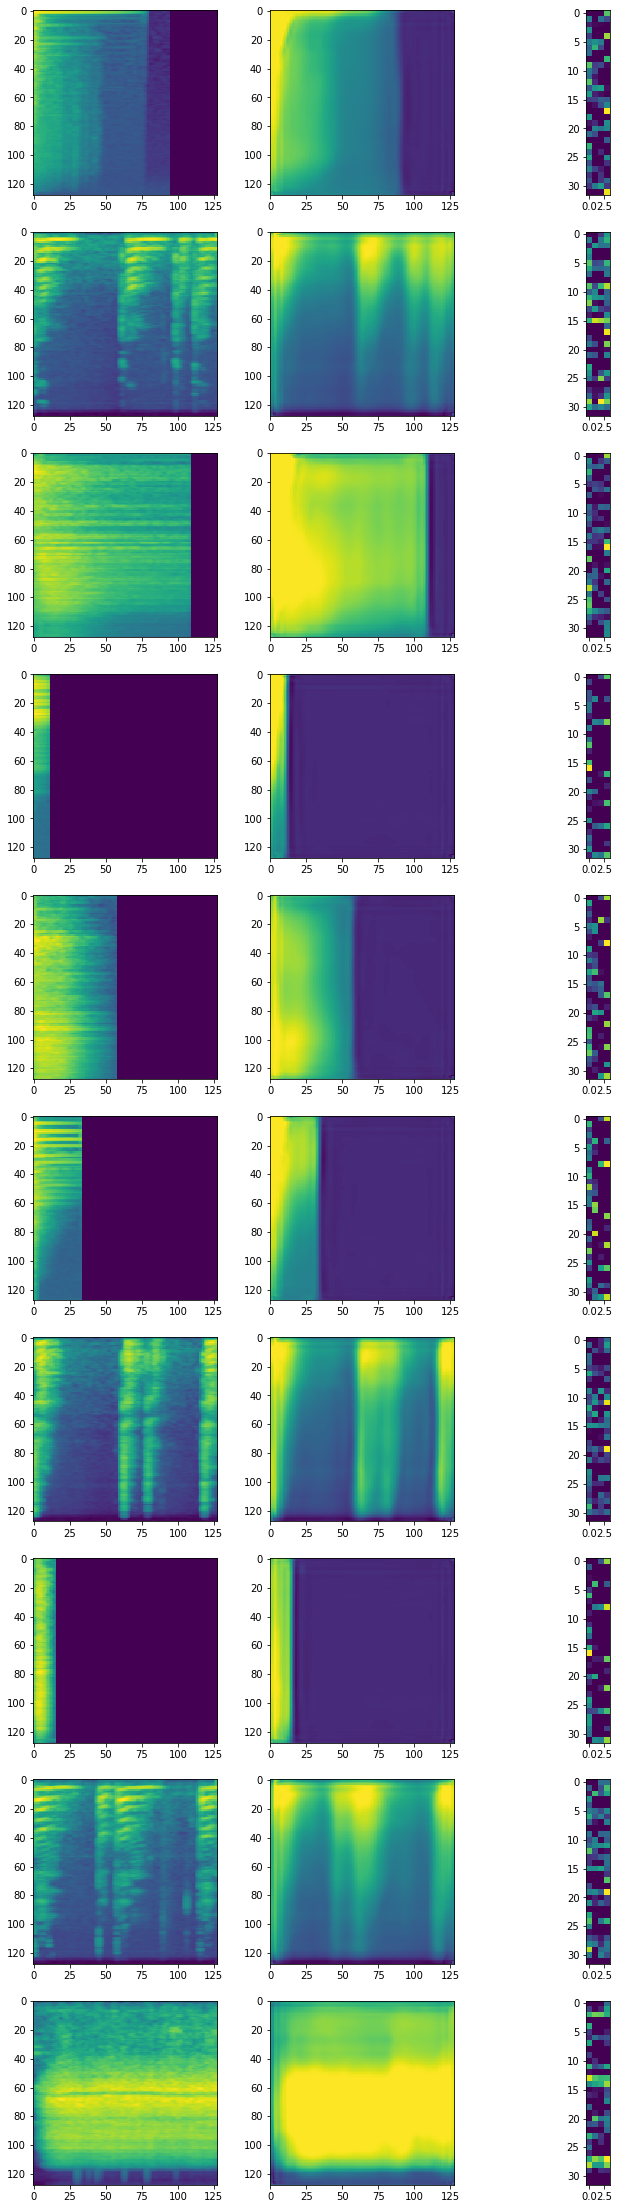

In [21]:
model_wide.eval()
imshow_ae_output(model_wide, common_set, 10, random_seed=455)

In [ ]:
vocal_splitter = DataSplit(vocal_sketch_dataset, shuffle=True, test_train_split=1)
vocal_loaders = {
    'train': vocal_splitter.get_train_loader(),
    'valid': vocal_splitter.get_validation_loader()
}

In [ ]:
vocal_model = ConvAE()
vocal_optimizer = torch.optim.Adam(vocal_model.parameters())

In [ ]:
vocal_runner = ConvAERunner()
vocal_runner.train(
    model=vocal_model, 
    optimizer=vocal_optimizer, 
    loaders=vocal_loaders,
    num_epochs=10,
    verbose=True,
    timeit=False,
    logdir="../logs/conv_ae_vocal_only"
)

In [ ]:
imshow_ae_output(vocal_model, vocal_sketch_dataset, 10)

In [ ]:
vocal_sketch_dataset_unnorm = SampleSet(glob.glob('../data/vocal_imitations_sketch_included/included/*.wav'))
drum_machines_dataset_unnorm = SampleSet(glob.glob('../data/200DrumMachines/*/*.wav'))
common_set_unnorm = ConcatDataset([vocal_sketch_dataset_unnorm, drum_machines_dataset_unnorm])

In [ ]:
model_unnorm = ConvAE()
model_unnorm.load_state_dict(torch.load('../logs/conv_ae_2/checkpoints/train.20.pth')['model_state_dict'])

In [ ]:
imshow_ae_output(model_unnorm, common_set_unnorm, 10)